In [3]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf #version 1.6
from sklearn.preprocessing import MinMaxScaler

C:\Users\HP\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
data_source = 'kaggle' 

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '85ANWNGILCY27HMS'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    
    # Store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


In [5]:
df = df.sort_values('Date')
df.head()
df.tail()


,Date,Open,High,Low,Close
12070,2017-11-06,21.47,21.53,21.38,21.44
12071,2017-11-07,21.47,21.47,21.32,21.38
12072,2017-11-08,21.34,21.47,21.24,21.42
12073,2017-11-09,21.27,21.40,21.15,21.34
12074,2017-11-10,21.25,21.31,21.14,21.23


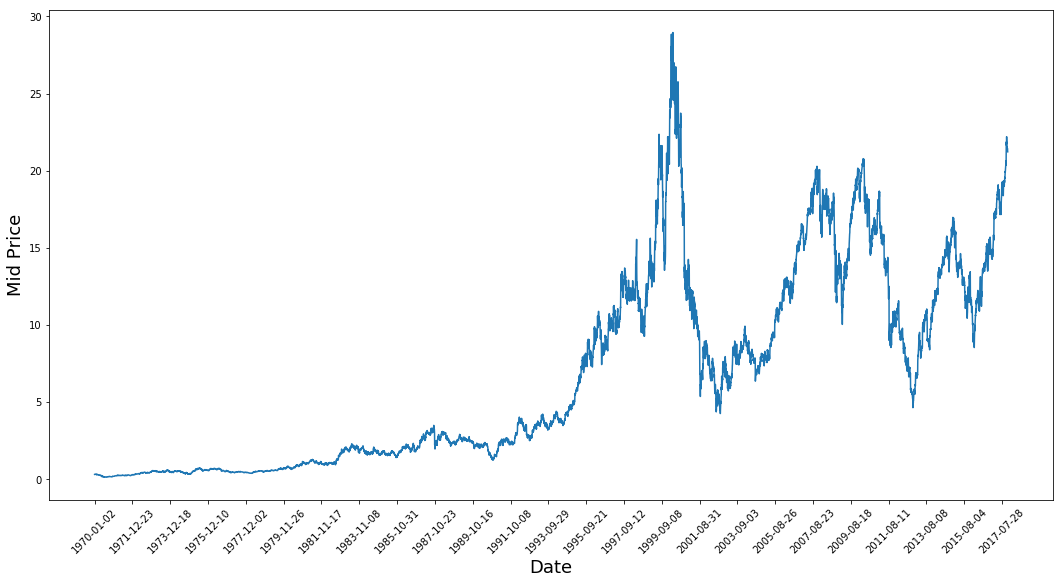

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


In [7]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

In [8]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

In [9]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [10]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [11]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [12]:
# Now perform exponential moving average smoothing
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [13]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


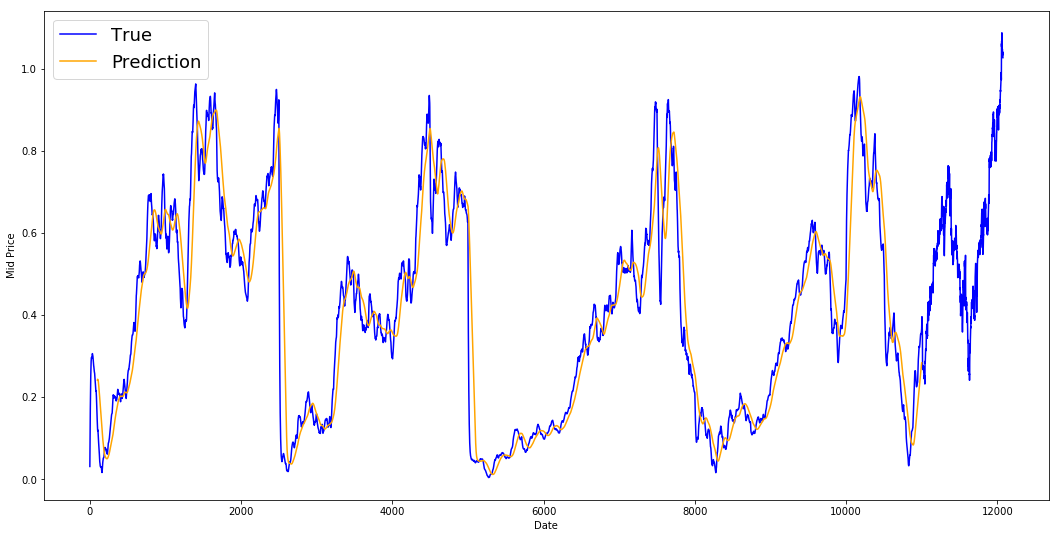

In [14]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [15]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


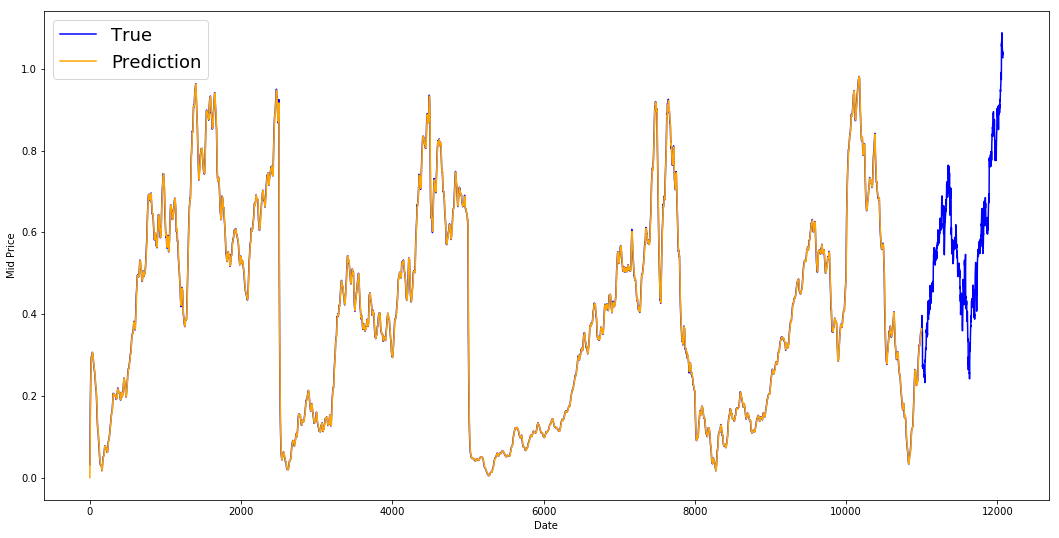

In [16]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [17]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels
    
    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.03143791 0.6904868  0.82829314 0.32585657 0.11600105]

	Output: [0.08698314 0.6904868  0.8329321  0.33078218 0.12158521]


Unrolled index 1
	Inputs:  [0.06067836 0.6890754  0.8325337  0.32857886 0.11785509]

	Output: [0.06067836 0.68685144 0.8325337  0.33421066 0.11785509]


Unrolled index 2
	Inputs:  [0.08698314 0.68685144 0.8329321  0.33078218 0.11946969]

	Output: [0.15261841 0.6858036  0.8329321  0.33355275 0.11946969]


Unrolled index 3
	Inputs:  [0.11098009 0.6858036  0.83294916 0.33219692 0.12106793]

	Output: [0.17132245 0.6826334  0.83387965 0.33219692 0.12192084]


Unrolled index 4
	Inputs:  [0.132895   0.6848606  0.833369   0.33355275 0.12158521]

	Output: [0.17132245 0.680175   0.83387965 0.33650374 0.12192084]


In [18]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [19]:
# Input data.
train_inputs, train_outputs = [],[]

# We unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [20]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [21]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=
                       False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format.
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [22]:
''' When calculating the loss we need to be careful about the exact form, because we calculate 
loss of all the unrolled steps at the same time
Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps'''

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [23]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [24]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(11000,12000,50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized
Average loss at step 1: 2.685994
	Test MSE: 0.07766
	Finished Predictions
Average loss at step 2: 0.172990
	Test MSE: 0.00890
	Finished Predictions
Average loss at step 3: 0.078720
	Test MSE: 0.00286
	Finished Predictions
Average loss at step 4: 0.064686
	Test MSE: 0.00283
	Finished Predictions
Average loss at step 5: 0.056329
	Test MSE: 0.00286
	Finished Predictions
Average loss at step 6: 0.052636
	Test MSE: 0.00258
	Finished Predictions
Average loss at step 7: 0.051288
	Test MSE: 0.00263
	Finished Predictions
Average loss at step 8: 0.049714
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 9: 0.049496
	Test MSE: 0.00238
	Finished Predictions
Average loss at step 10: 0.047412
	Test MSE: 0.00349
	Finished Predictions
Average loss at step 11: 0.043521
	Test MSE: 0.00237
	Finished Predictions
Average loss at step 12: 0.043813
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 13: 0.038503
	Test MSE: 0.00246
	Finished Predictions
Average loss at step 1

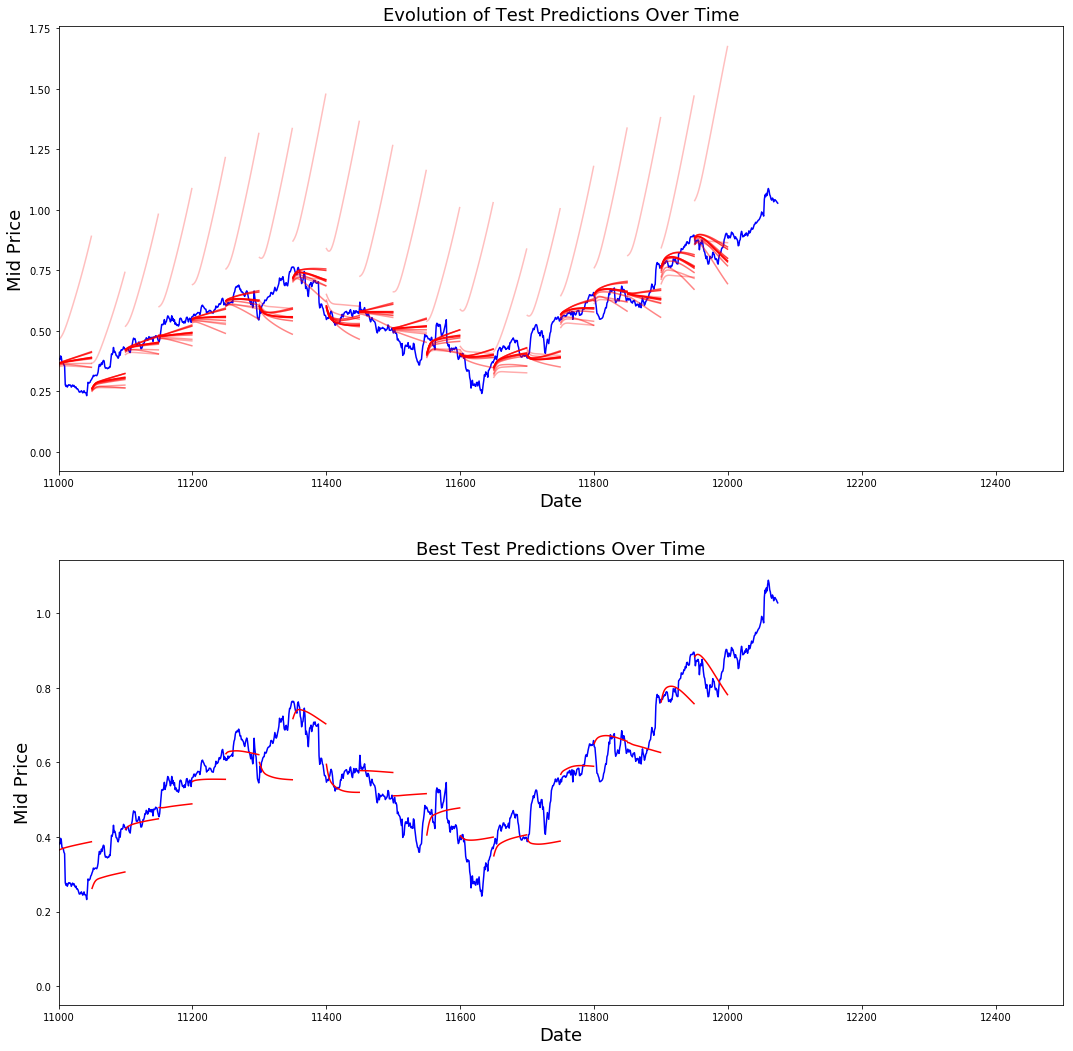

In [25]:
best_prediction_epoch = 23 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()